The idea of this post is that anyone can try to train their own image classifier on almost anything

# Dataset creation 

First lets import all packages we will need

In [1]:
import os, glob
import random
import numpy as np
import copy
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import dill

import warnings
warnings.filterwarnings('ignore')

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


## Step 1  Downloading images from google images

We need to collect data first. 

There is a tool https://github.com/rushilsrivastava/image-scrappers 

## Step 2 Clean the data

Remove all non .jpg images

There need to be code, that removes all .png etc images from raw data

In [2]:
folder = './data/'
for class_name in os.listdir(folder):
    images = os.listdir(folder+class_name)
    for im in images:
        image_path = folder+class_name+'/'+im
        if not im[-4:]=='.jpg':
            print('Not .jpg file: {}'.format(im) + ' is not valid, deleting!')
            os.remove(image_path)
        else:
            try:
                Image.open(image_path)
            except:
                print('Image: {}'.format(im) + ' is not valid, deleting!')
                os.remove(image_path)
                

Make dictionary with mapping from class names to indexes

In [3]:
class_mapping = {}
for name in os.listdir(folder):
    class_mapping[name] = len(class_mapping)
print(class_mapping)

{'moderndancer': 2, 'ballerina': 1, 'womanineveningdress': 0}


## Step 3 Split to train/validation and form a propper folder structure

In [4]:
from_folder = './data/'
to_folder = './dataset/'

In [5]:
folders = os.listdir(from_folder)

In [6]:
folders

['womanineveningdress', 'ballerina', 'moderndancer']

In [7]:
def count_images(root_dir):
    '''
    Counts number of images in each folder inside root folder. 
    '''
    folders = os.listdir(root_dir)
    counter = {}
    for folder in folders:
        files = os.listdir(root_dir+folder)
        counter[folder] = len(files)
        
    return counter   

In [8]:
def split(indexes, max_number=None, train_fraction=0.8):
    ''' 
    Splits indexes into train and validation part according to specified fraction.
    '''
    ind = copy.deepcopy(indexes)
    np.random.shuffle(ind)
    
    if not max_number==None:
        ind = ind[:max_number]
        
    p = round(len(ind)*train_fraction)

    return [ind[:p], ind[p:]]

In [9]:
def split_and_copy(from_folder, to_folder, train_fraction = 0.8):
    ''' 
    Move and rename downloaded images into train/ and validation/ directories. 
    Split according to train_fraction. 
    '''
    folders = os.listdir(from_folder)
    
    counter = count_images(from_folder)
    min_img_number = min([counter[a] for a in counter])
    
    for ind, folder in enumerate(folders):
        images = os.listdir(from_folder+folder)
        indexes = list(range(len(images)))
        train_indexes, validation_indexes = split(indexes, min_img_number, train_fraction)
        
        # Check if directories exist and delete all the files in them if not.
        dest_train_folder = to_folder+'train/'+folder
        dest_validation_folder = to_folder+'validation/'+folder
        
        if not os.path.exists(dest_train_folder):
            os.makedirs(dest_train_folder)
        
        if not os.path.exists(dest_validation_folder):
            os.makedirs(dest_validation_folder)
            
        try:
            glob.glob(dest_train_folder+'/*')
            shutil.rmtree(dest_train_folder+'/*')
        except:
            pass
        
        try:
            glob.glob(dest_validation_folder+'/*')
            shutil.rmtree(dest_validation_folder+'/*')
        except:
            pass
        
        for i, image in enumerate([images[i] for i in train_indexes]):
            from_path = from_folder+folder+'/'+image
            to_path = dest_train_folder+'/'+'im'+str(i).zfill(3)+'.jpg'
            shutil.copy(from_path, to_path)
            
        for i, image in enumerate([images[i] for i in validation_indexes]):
            from_path = from_folder+folder+'/'+image
            to_path = dest_validation_folder+'/'+'im'+str(i).zfill(3)+'.jpg'
            shutil.copy(from_path, to_path)


In [10]:
split_and_copy(from_folder, to_folder, train_fraction=0.8)

## Step 4 Deal with image augmentation

./data/ballerina/ballerinainlongtulle_1045.jpg


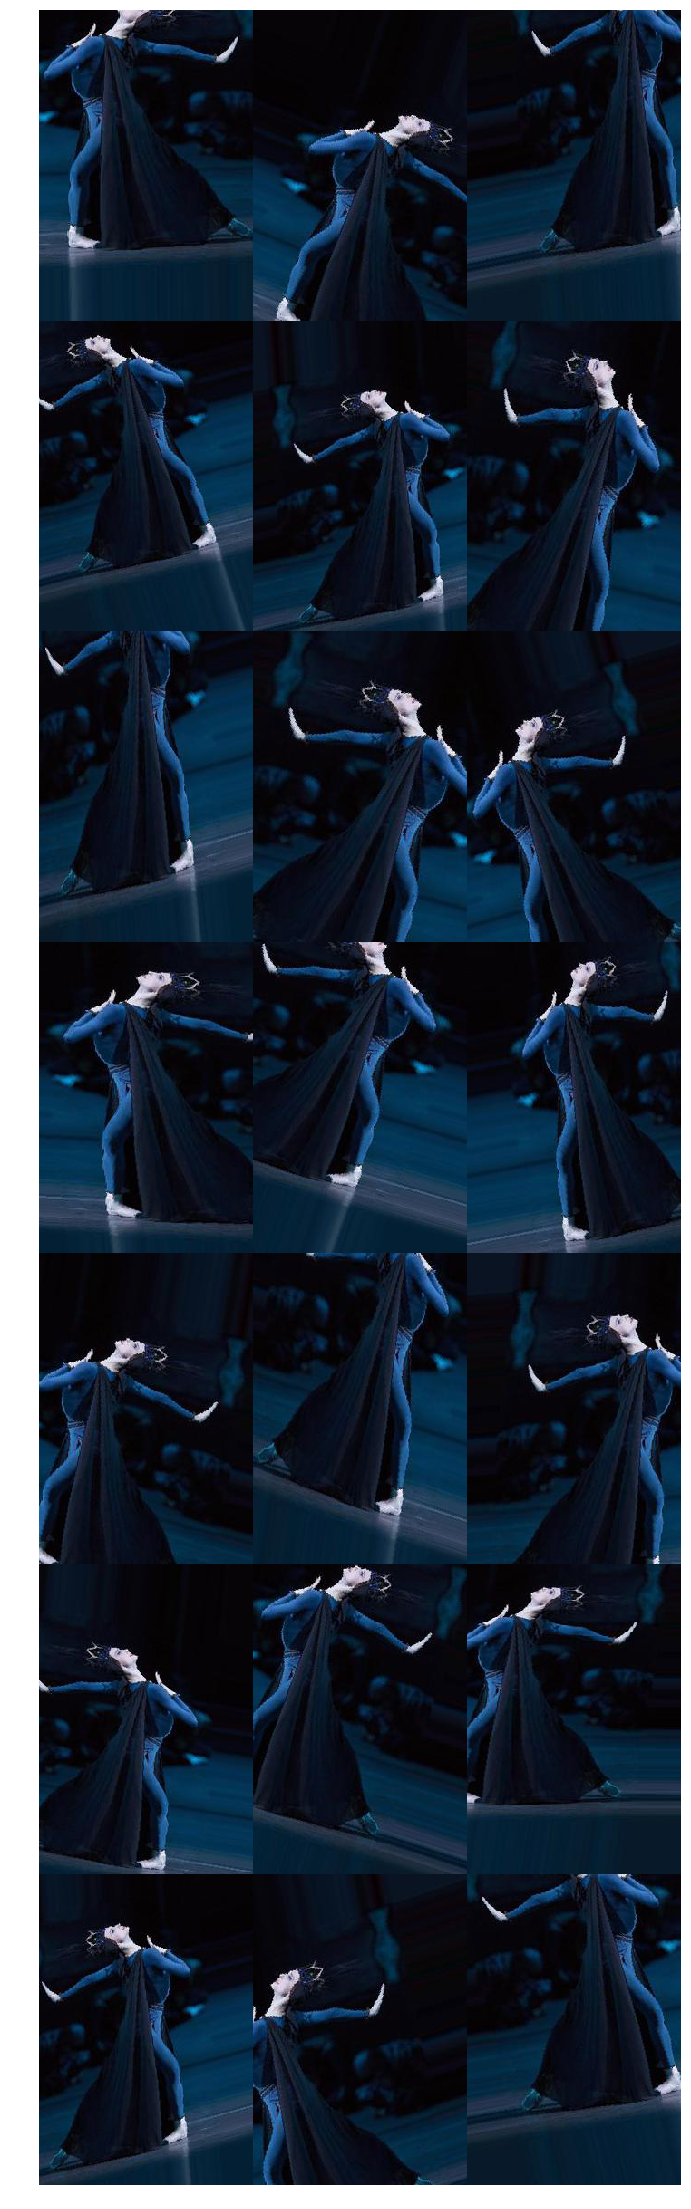

In [29]:
# Clean the priview directory
preview_folder = './augmentation_preview'

try:
    shutil.rmtree(preview_folder)
    os.makedirs(preview_folder)
except:
    os.makedirs(preview_folder)
    
# Produce 20 examples of data augmentation
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

data_folder = './data/ballerina'
image_path = data_folder+'/'+random.choice(os.listdir(data_folder))
print(image_path)
#image_path = './data/Sophia_3.jpg'

img = load_img(image_path)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=preview_folder, save_prefix='im', save_format='jpg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        
# Plot examples
def gallery(array, ncols=3):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape((nrows, ncols, height, width, intensity))
              .swapaxes(1,2)
              .reshape((height*nrows, width*ncols, intensity)))
    return result

im_array = []

for image in os.listdir(preview_folder):
    image_path = preview_folder+'/'+image
    im = np.asarray(Image.open(image_path))
    im_array.append(im)

plt.figure(figsize=(40, 40))
plt.axis('off')
plt.imshow(gallery(np.array(im_array)))
plt.show()

## Step 5 Train classifier

In [30]:
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from confusion_matrix import plot_confusion_matrix
from plot_history import plot

### Training convnet from scratch

In [31]:
def basic_cnn_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # the model so far outputs 3D feature maps (height, width, features)

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-3, decay=1e-3, momentum=0.9),
              metrics=['accuracy'])
    
    return model
cnn_model = basic_cnn_model()

In [32]:
batch_size = 32

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        './dataset/train',  # this is the target directory
        target_size=(256, 256),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        './dataset/validation',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')

Found 774 images belonging to 3 classes.
Found 195 images belonging to 3 classes.


In [33]:
filepath="./weights/custom_cnn_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = cnn_model.fit_generator(
        train_generator,
        steps_per_epoch=5000 // batch_size,
        epochs=25,
        validation_data=validation_generator,
        validation_steps=195 // batch_size,
        callbacks = callbacks_list
)

Epoch 1/25
156/156 [==============================] - 104s - loss: 1.0136 - acc: 0.4932 - val_loss: 0.9131 - val_acc: 0.5365
Epoch 2/25
156/156 [==============================] - 97s - loss: 0.9410 - acc: 0.5395 - val_loss: 0.8866 - val_acc: 0.6319
Epoch 3/25
156/156 [==============================] - 97s - loss: 0.9160 - acc: 0.5599 - val_loss: 0.8346 - val_acc: 0.6748
Epoch 4/25
156/156 [==============================] - 97s - loss: 0.8940 - acc: 0.5817 - val_loss: 0.8170 - val_acc: 0.6564
Epoch 5/25
156/156 [==============================] - 99s - loss: 0.8686 - acc: 0.5972 - val_loss: 0.8217 - val_acc: 0.6626
Epoch 6/25
156/156 [==============================] - 96s - loss: 0.8616 - acc: 0.6083 - val_loss: 0.7946 - val_acc: 0.6626
Epoch 7/25
156/156 [==============================] - 98s - loss: 0.8418 - acc: 0.6172 - val_loss: 0.7439 - val_acc: 0.7178
Epoch 8/25
156/156 [==============================] - 98s - loss: 0.8443 - acc: 0.6165 - val_loss: 0.7414 - val_acc: 0.6994
Epoch 9

Lets plot train and validation accuracy

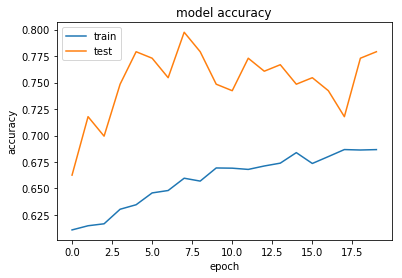

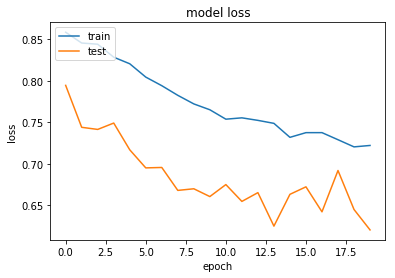

In [34]:
plot(history, 5)

Lets plot confusion matrix

Found 195 images belonging to 3 classes.
Confusion matrix, without normalization
[[48  9  8]
 [ 8 50  7]
 [ 6  3 56]]


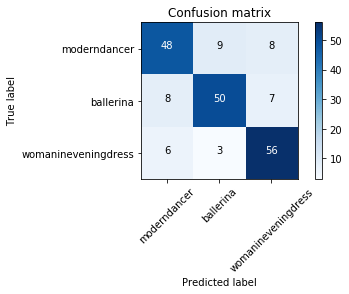

In [35]:
test_gen = test_datagen.flow_from_directory(
        './dataset/validation',
        target_size=(256, 256),
        batch_size=1,
        class_mode='categorical',
        seed=0,
        shuffle=False)

mapping = test_gen.class_indices
preds = [np.argmax(i) for i in cnn_model.predict_generator(test_gen, steps=195)]
labels = [mapping[f.split('/')[0]] for f in test_gen.filenames]
plot_confusion_matrix(labels, preds, classes = list(class_mapping.keys()))

In [36]:
cnn_test_model = basic_cnn_model()
cnn_test_model.load_weights('./weights/custom_cnn_12-0.80.hdf5')
score = cnn_test_model.evaluate_generator(test_gen, steps = 195)
print("Our new best accuracy: {}".format(score[1]))

Our new best accuracy: 0.7743589743589744


### Training only dence layers with data augmentation

In [40]:
from keras.applications.vgg16 import VGG16

In [43]:
def vgg():# build the VGG16 network
    model = VGG16(weights='imagenet', include_top=False, input_shape = (256,256,3))
    last = model.output
    x = Flatten(input_shape=model.output_shape[1:])(last)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(model.input, output) 
    
    # set the first 20 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    for layer in model.layers[:20]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-3, decay=1e-3, momentum=0.9),
              metrics=['accuracy'])
    return model

In [44]:
vgg_model = vgg()

In [45]:
filepath="./weights/vgg16_cnn_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_vgg = vgg_model.fit_generator(
        train_generator,
        steps_per_epoch=5000 // batch_size,
        epochs=25,
        validation_data=validation_generator,
        validation_steps=195 // batch_size,
        callbacks = callbacks_list
)

Epoch 1/25
156/156 [==============================] - 105s - loss: 0.8543 - acc: 0.5950 - val_loss: 0.6303 - val_acc: 0.7178
Epoch 2/25
156/156 [==============================] - 97s - loss: 0.6718 - acc: 0.6999 - val_loss: 0.5311 - val_acc: 0.7914
Epoch 3/25
156/156 [==============================] - 100s - loss: 0.6165 - acc: 0.7183 - val_loss: 0.4378 - val_acc: 0.8405
Epoch 4/25
156/156 [==============================] - 101s - loss: 0.5712 - acc: 0.7515 - val_loss: 0.3911 - val_acc: 0.8528
Epoch 5/25
156/156 [==============================] - 100s - loss: 0.5134 - acc: 0.7772 - val_loss: 0.4277 - val_acc: 0.8344
Epoch 6/25
156/156 [==============================] - 101s - loss: 0.4888 - acc: 0.7923 - val_loss: 0.3209 - val_acc: 0.8712
Epoch 7/25
156/156 [==============================] - 100s - loss: 0.5067 - acc: 0.7851 - val_loss: 0.4017 - val_acc: 0.8466
Epoch 8/25
156/156 [==============================] - 95s - loss: 0.4753 - acc: 0.8073 - val_loss: 0.3415 - val_acc: 0.8773
Ep

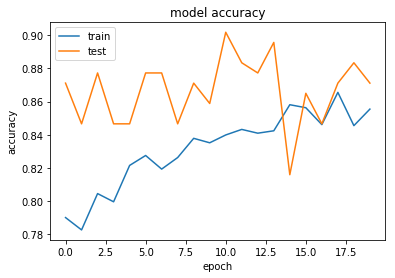

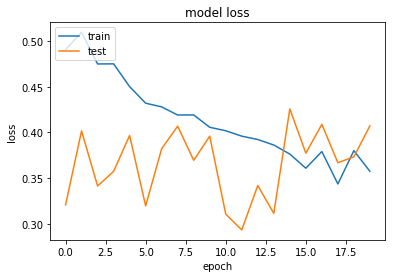

In [46]:
plot(history_vgg, 5)

Found 195 images belonging to 3 classes.
Confusion matrix, without normalization
[[54  7  4]
 [ 5 58  2]
 [ 4  1 60]]


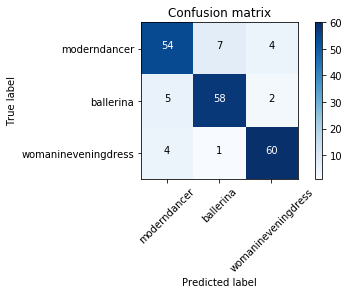

In [47]:
test_gen = test_datagen.flow_from_directory(
        './dataset/validation',
        target_size=(256, 256),
        batch_size=1,
        class_mode='categorical',
        seed=0,
        shuffle=False)

mapping = test_gen.class_indices
preds = [np.argmax(i) for i in vgg_model.predict_generator(test_gen, 195)]
labels = [mapping[f.split('/')[0]] for f in test_gen.filenames]
plot_confusion_matrix(labels, preds, classes = list(class_mapping.keys()))

In [48]:
vgg_test_model = vgg()
vgg_test_model.load_weights('./weights/vgg16_cnn_15-0.90.hdf5')
score = vgg_test_model.evaluate_generator(test_gen, steps = 195)
print("Our new best accuracy: {}".format(score[1]))

Our new best accuracy: 0.8615384615384616


### Finetuning dence and convolutional layers

In [49]:
finetune_model = vgg()

In [50]:
# Set last convolutional block to be trainable
for layer in finetune_model.layers:
    layer.trainable = True
    
for layer in finetune_model.layers[:15]:
    layer.trainable = False

In [51]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
finetune_model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=1e-4, decay=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [52]:
finetune_model.load_weights('./weights/vgg16_cnn_15-0.90.hdf5')

We need to decreas

In [53]:
filepath="./weights/vgg16_finetune_cnn_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history_vgg_finetune = finetune_model.fit_generator(
        train_generator,
        steps_per_epoch=5000 // batch_size,
        epochs=25,
        validation_data=validation_generator,
        validation_steps=195 // batch_size,
        callbacks = callbacks_list
)

Epoch 1/25
156/156 [==============================] - 104s - loss: 0.3708 - acc: 0.8591 - val_loss: 0.2261 - val_acc: 0.9018
Epoch 2/25
156/156 [==============================] - 101s - loss: 0.3334 - acc: 0.8695 - val_loss: 0.3897 - val_acc: 0.8528
Epoch 3/25
156/156 [==============================] - 101s - loss: 0.3089 - acc: 0.8821 - val_loss: 0.4103 - val_acc: 0.8650
Epoch 4/25
156/156 [==============================] - 102s - loss: 0.3046 - acc: 0.8798 - val_loss: 0.3549 - val_acc: 0.8712
Epoch 5/25
156/156 [==============================] - 99s - loss: 0.2855 - acc: 0.8924 - val_loss: 0.3573 - val_acc: 0.8834
Epoch 6/25
156/156 [==============================] - 99s - loss: 0.2655 - acc: 0.8956 - val_loss: 0.2902 - val_acc: 0.9018
Epoch 7/25
156/156 [==============================] - 99s - loss: 0.2545 - acc: 0.9010 - val_loss: 0.3056 - val_acc: 0.8773
Epoch 8/25
156/156 [==============================] - 98s - loss: 0.2523 - acc: 0.9075 - val_loss: 0.3467 - val_acc: 0.8834
Epoc

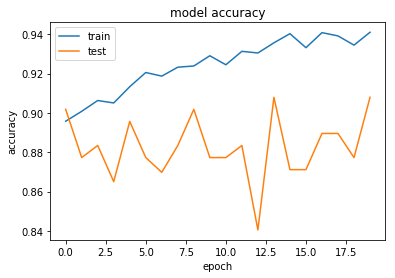

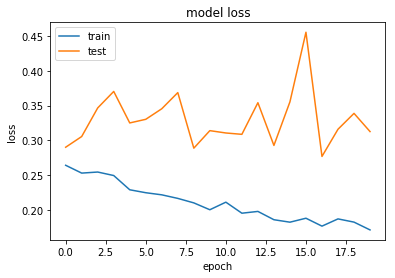

In [54]:
plot(history_vgg_finetune, 5)

Found 195 images belonging to 3 classes.
Confusion matrix, without normalization
[[54  8  3]
 [ 4 59  2]
 [ 4  1 60]]


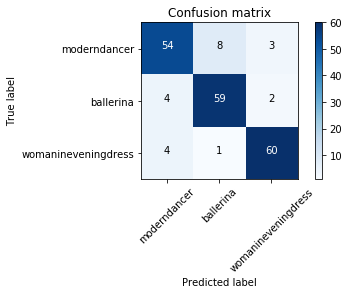

In [55]:
test_gen = test_datagen.flow_from_directory(
        './dataset/validation',
        target_size=(256, 256),
        batch_size=1,
        class_mode='categorical',
        seed=0,
        shuffle=False)

mapping = test_gen.class_indices
preds = [np.argmax(i) for i in finetune_model.predict_generator(test_gen, 195)]
labels = [mapping[f.split('/')[0]] for f in test_gen.filenames]
plot_confusion_matrix(labels, preds, classes = list(class_mapping.keys()))

In [56]:
vgg_test_model = vgg()
vgg_test_model.load_weights('./weights/vgg16_finetune_cnn_18-0.91.hdf5')
score = vgg_test_model.evaluate_generator(test_gen, steps = 195)
print("Our new best accuracy: {}".format(score[1]))

Our new best accuracy: 0.8871794871794871


Now, with fine-tuned images our model finally generalize well between ballerina and woman in evening dress!